# ブラックボックス最適化と強化学習
https://ee227c.github.io/code/lecture20.html

## ライブラリ

In [6]:
%matplotlib inline

import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plotters import error_plot, kwargs, setup_layout

np.random.seed(1)
setup_layout()

## ブラックボックス最適化

### ランダムサーチ

#### 黄金分割法

In [7]:
# 黄金分割法（golden section search）
def gss(f, a, b, tol=1e-5):
    """Golden section search.
    
    区間[a, b]でf(x)が最小になるxを探す
    2分探索において，区間を選ぶ方法を工夫したもの：区間を黄金比で内分する
    f: [a, b] 上の単峰関数
    """

    gr = (np.sqrt(5) + 1) / 2  # 黄金比
    c = b - (b - a) / gr # 探索点:aとbを黄金比で内分する
    d = a + (b - a) / gr # 探索点:aとbを黄金比で内分する

    while abs(c - d) > tol:
        if f(c) < f(d):
            b = d
        else:
            a = c

        # 新しい内分点を設定する
        c = b - (b - a) / gr
        d = a + (b - a) / gr
    return (b + a) / 2

#### ランダムサーチ

In [12]:
def random_search(oracle, init, num_steps, line_search=gss):
    """Random search.
    
    oracle: 関数
    init: 初期点
    num_steps: 最大反復回数
    line_search: 直線探索アルゴリズム
    """
    iterates = [init]

    for _ in range(num_steps):
        # 乱数を生成して，それを使って探索点を更新する
        d = np.random.normal(0, 100, size=init.shape) # 平均0，標準偏差100の正規分布に従う乱数を生成
        d /= np.linalg.norm(d) # dを単位ベクトルにする
        x = iterates[-1] # 最後の探索点
        # 直線探索
        eta = line_search(lambda step: oracle(x + step * d), -1, 1)
        iterates.append(x + eta * d)
    return iterates

In [13]:
A = np.random.normal(0, 1, (100, 100)) # 平均0，標準偏差1の正規分布に従う乱数を生成, 100x100の行列
b = np.random.normal(0, 1, (100,)) # 平均0，標準偏差1の正規分布に従う乱数を生成, 100次元のベクトル
def least_squares(x):
    return 0.5*np.linalg.norm(A.dot(x)-b)**2 # 二乗誤差

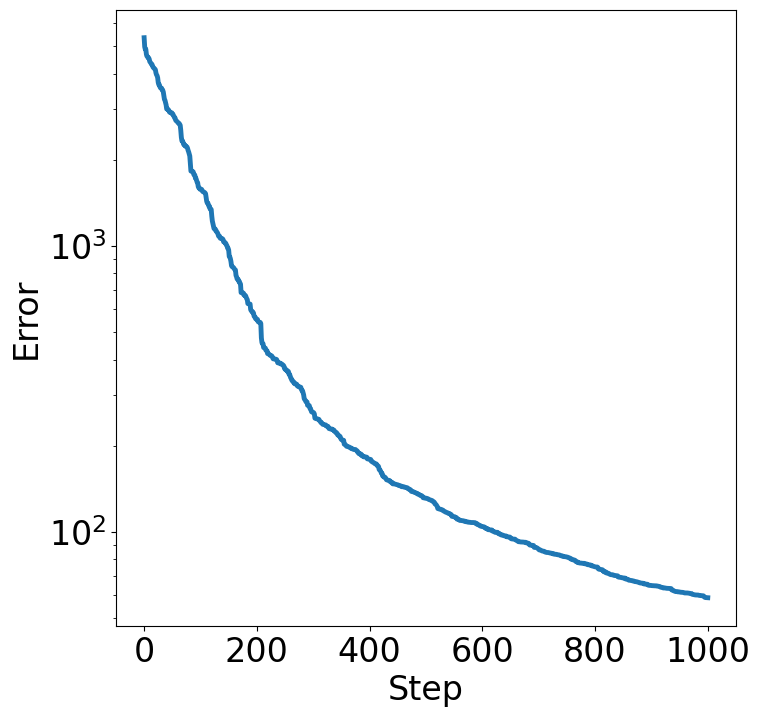

In [14]:
xs = random_search(least_squares, b, 1000)
error_plot([least_squares(x) for x in xs])

### ネルダー・ミード法

In [15]:
def nelder_mead(oracle, init, num_steps):
    iterates = [init]
    scipy.optimize.minimize(oracle, init, method='Nelder-Mead', callback=lambda x:iterates.append(x), options={'maxiter': num_steps})
    return iterates

In [16]:
def himmelblau(x):
    """Himmelblau's function."""
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 -7)**2

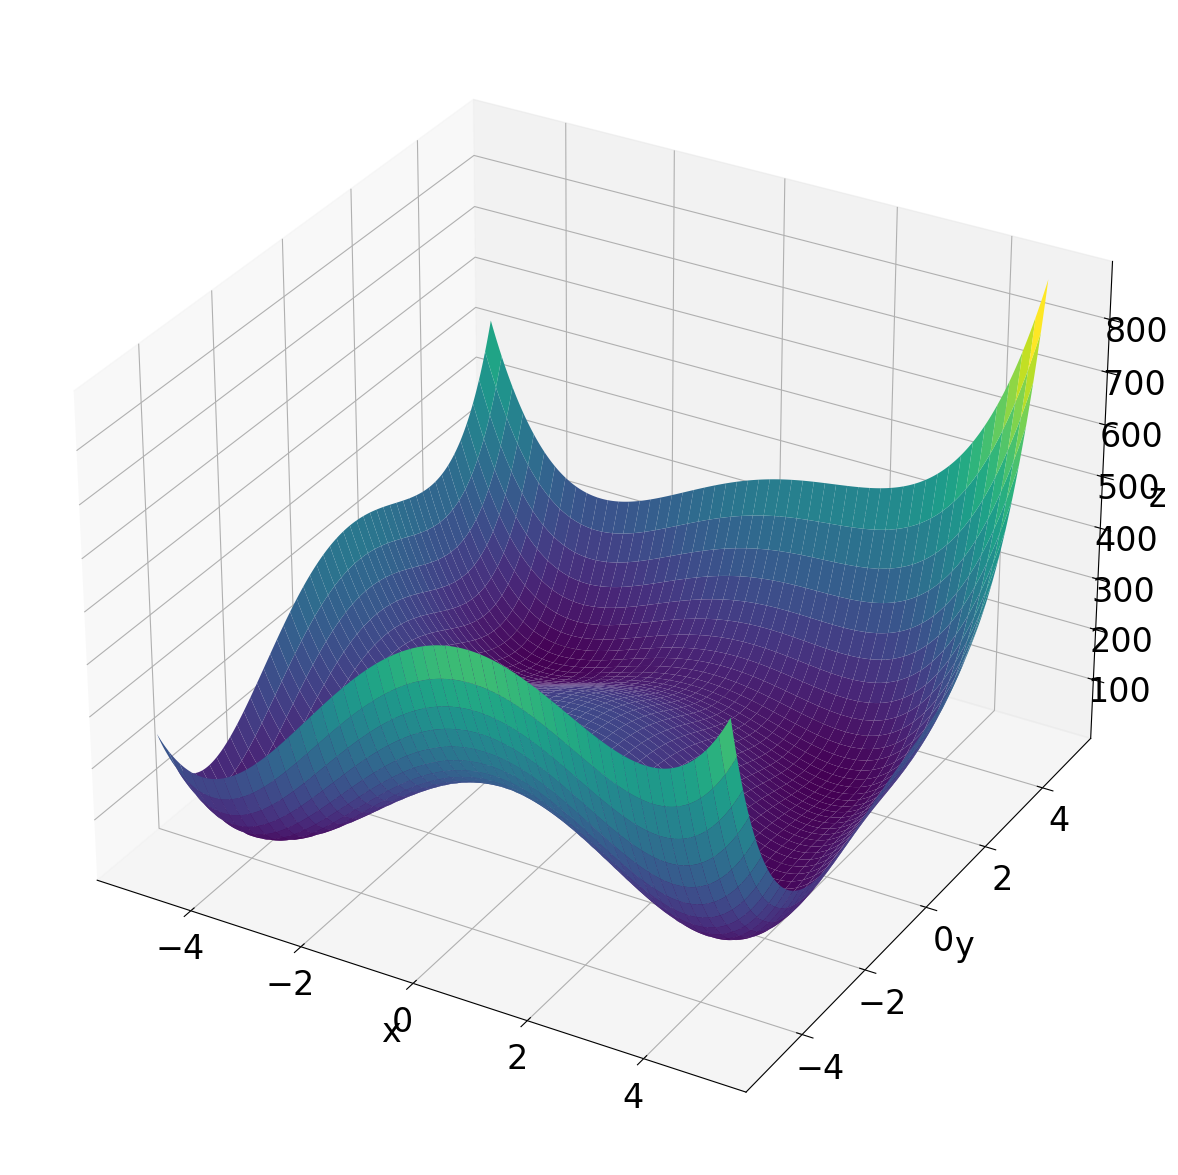

In [20]:
points = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(points, points)
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.plot_surface(X, Y, himmelblau(np.array([X, Y])), cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

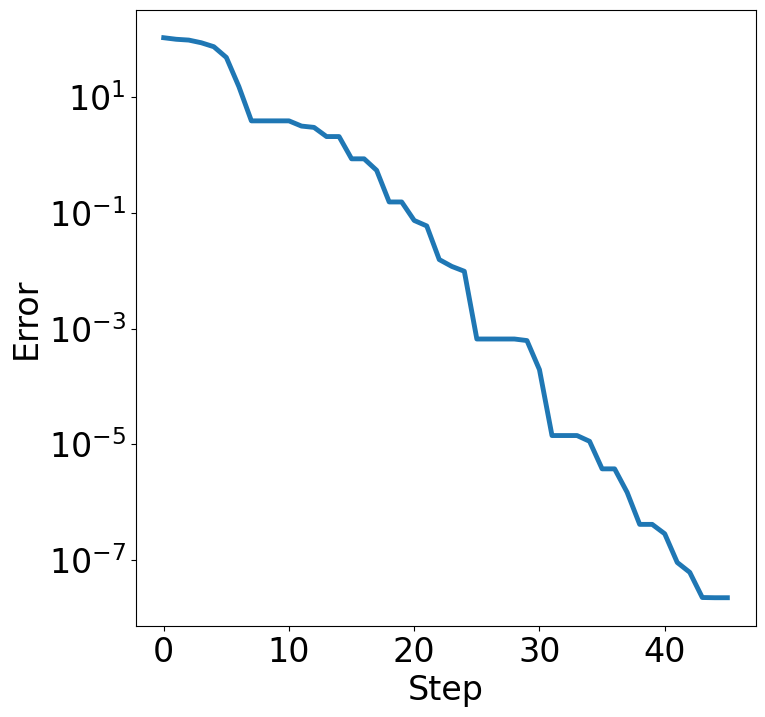

In [21]:
xs = nelder_mead(himmelblau, [1,1], 50) # ネルダー・ミード法
error_plot([himmelblau(x) for x in xs])

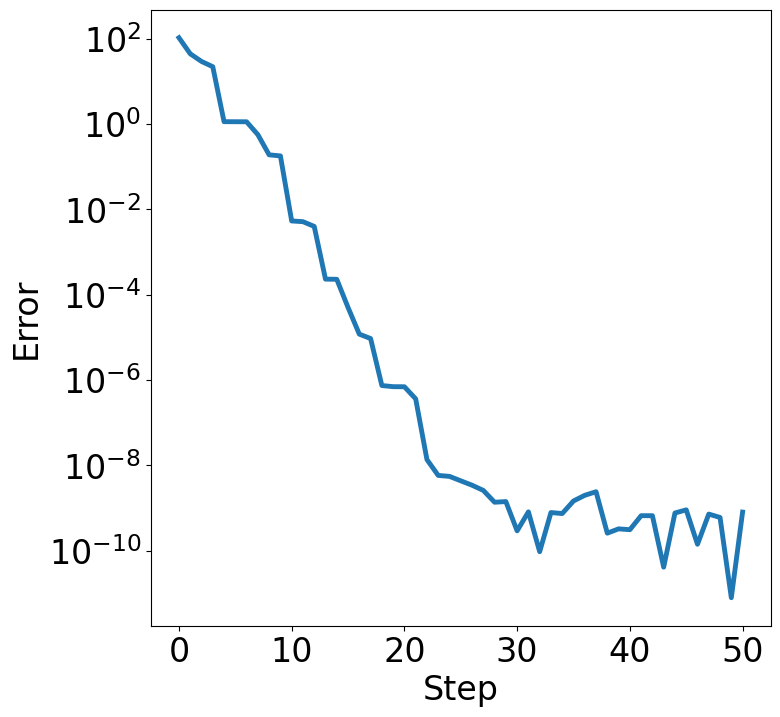

In [22]:
xs = random_search(himmelblau, np.array([1,1]), 50) # ランダムサーチ
error_plot([himmelblau(x) for x in xs])

## フラッピーバード

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

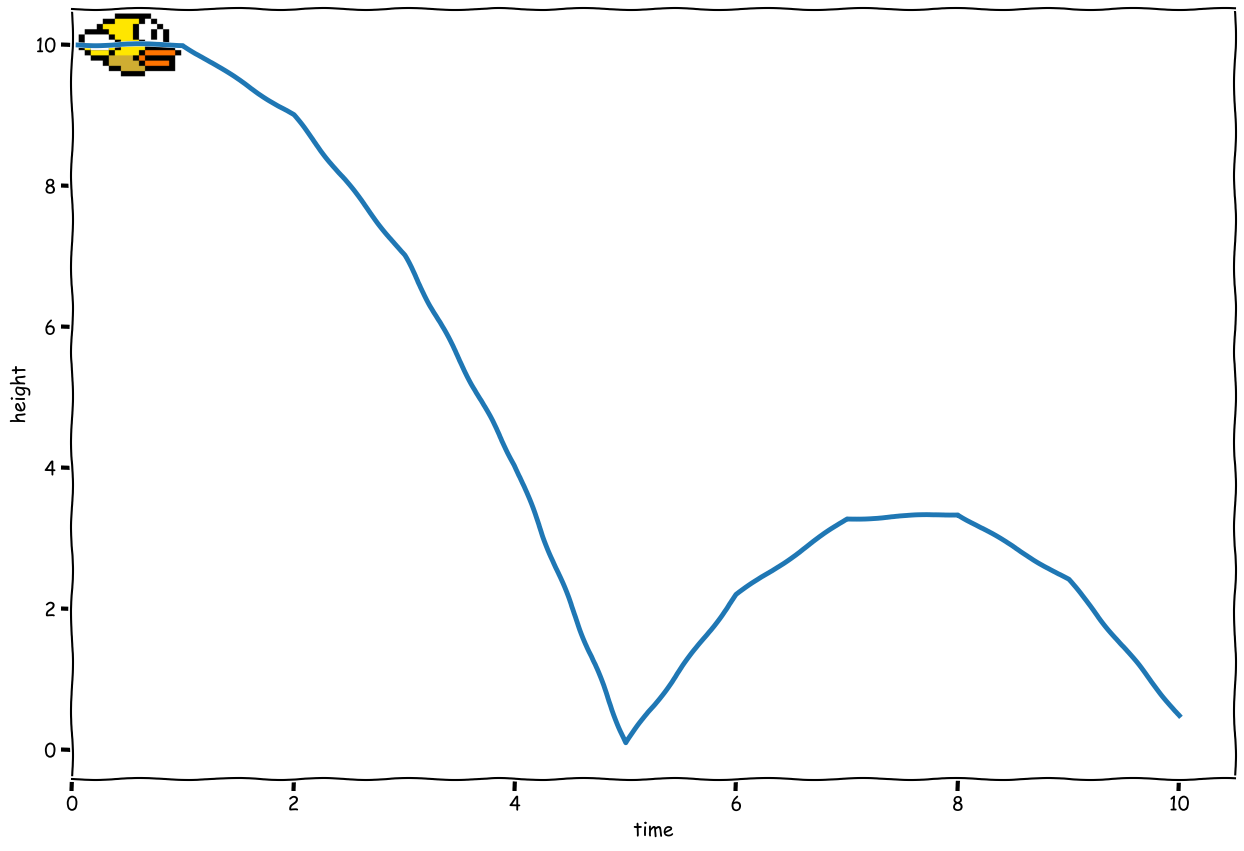

In [31]:
def flappy_bird(state, action):
    """Flappy bird dynamical system.
    
    state: pair of downward velocity and height
    action: upward acceleration
    
    Returns new state."""
    v, h = state
    g = 1. # acceleration due to gravity
    k = 0.01 # drag coefficient
    m = 1 # mass
    return (v + g - (k/m)*v - action, h - v)

def unroll(system, inits, policy, num_steps):
    """Unroll a dynamical system."""
    states = [inits[0]]
    actions = [inits[1]]
    for _ in range(num_steps):
        action = policy(states, actions)
        actions.append(action)
        states.append(system(states[-1], action))
    return states, actions

def example_policy(states, actions):
    """Accelerate upwards every 5 steps."""
    v, h = states[-1]
    if divmod(len(states), 5)[1] == 0:
        return 7
    else:
        return 0.

flappy_inits = [(0, 10.), 0]
states, actions = unroll(flappy_bird, flappy_inits, example_policy, 10)
heights = [h for (v, h) in states]

plt.xkcd(); fig = plt.figure(figsize=(15,10))
im = plt.imread('flappy.png')
fig.gca().imshow(im, aspect='auto', extent=(0, 1, 9.5, 10.5))
fig.figimage(im, 0, fig.bbox.ymax)
plt.ylabel('height'); plt.xlabel('time');
plt.plot(range(len(heights)), heights, **kwargs);

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

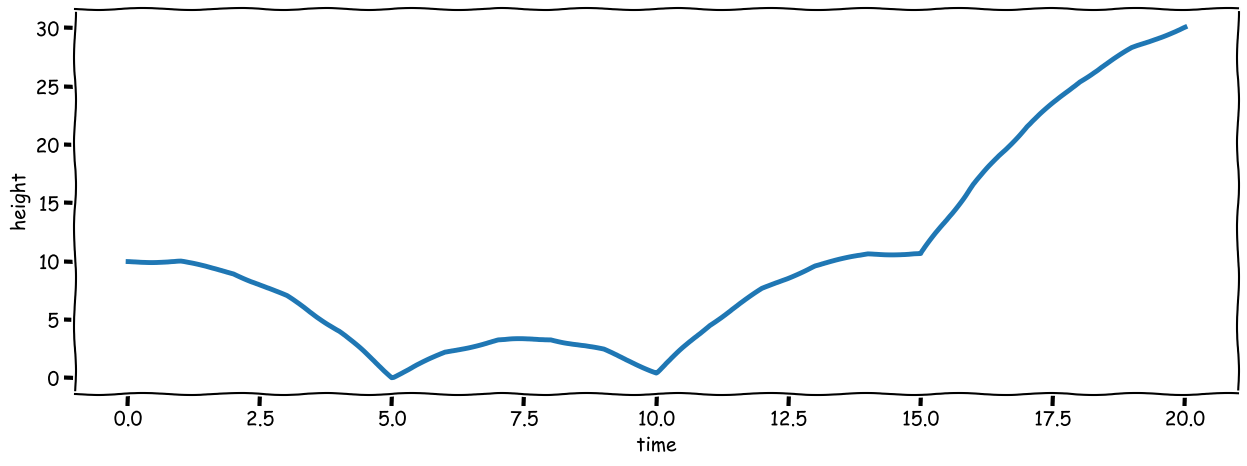

In [32]:
states, actions = unroll(flappy_bird, flappy_inits, example_policy, 20)
heights = [h for (v, h) in states]
plt.figure(figsize=(15,5))
plt.ylabel('height'); plt.xlabel('time')
plt.plot(range(len(heights)), heights, **kwargs);